[GitHub](https://github.com/elsanns/xai-nlp-notebooks/blob/master/electra_fine_tune_explain_captum_ig.ipynb)
# Content

---



This notebook contains an example of [fine-tuning](https://huggingface.co/transformers/training.html) an [Electra](https://huggingface.co/transformers/model_doc/electra.html) model on the [GLUE SST-2](https://nlp.stanford.edu/sentiment/index.html) dataset. After fine-tuning, the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) **interpretability** method is applied to compute tokens' attributions for each target class. 
* We will instantiate a pre-trained Electra model from the [Transformers](https://huggingface.co/transformers/) library. 
* The data is downloaded from the [nlp](https://huggingface.co/nlp/) library. The input text is tokenized with [ElectraTokenizerFast](https://huggingface.co/transformers/model_doc/electra.html#electratokenizerfast) tokenizer backed by HF [tokenizers](https://huggingface.co/transformers/main_classes/tokenizer.html) library.
* **Fine-tuning** for sentiment analysis is handled by the [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) class. 
* After fine-tuning, the [Integrated Gradients](https://captum.ai/api/integrated_gradients.html) interpretability algorithm will assign importance scores to
input tokens. We will use a **PyTorch** implementation from the [Captum](https://captum.ai/) library. 
  - The algorithm requires providing a reference sample (a baseline) since importance attribution is performed based on the model's output, as inputs change from reference values to the actual sample. 
  - The Integrated Gradients method satisfies the [completeness](http://theory.stanford.edu/~ataly/Talks/sri_attribution_talk_jun_2017.pdf) property. We will look at the sum of attributions for a sample and show that the sum approximates (explains) prediction's shift from the baseline value. 
* The final sections of this notebook contain a colour-coded **visualization** of attribution results made with *captum.attr.visualization* library.

The notebook is based on the [Hugging Face documentation](https://huggingface.co/) and the implementation of Integrated Gradients attribution methods is adapted from the Captum.ai
[Interpreting BERT Models (Part 1)](https://captum.ai/tutorials/Bert_SQUAD_Interpret).

# Installation & imports

---

In [32]:
!pip install transformers
# pyarrow version as required by nlp v. 0.3.0 (runtime restart in Colab)
!pip install "pyarrow==0.16.0"  
!pip install nlp
!pip install captum

In [33]:
from typing import Dict

import matplotlib.pyplot as plt
import nlp
import numpy as np
import pandas as pd
import torch
import transformers
from captum.attr import (IntegratedGradients, LayerIntegratedGradients,
                         configure_interpretable_embedding_layer,
                         remove_interpretable_embedding_layer)
from captum.attr import visualization as viz
from torch.utils.data import Dataset
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics)

transformers.__version__

'3.0.2'

# Model

---

Sentiment analysis is a classification task that requires assigning a label to an entire sentence (sequence). We will use a PyTorch implementation of [`ElectraForSequenceClassification`](https://huggingface.co/transformers/model_doc/electra.html#electraforsequenceclassification) from the Hugging Face library. A matching tokenizer implemented in the [`ElectraTokenizerFast`](https://huggingface.co/transformers/model_doc/electra.html#electratokenizerfast) class will handle tokenization.

In [34]:
model = ElectraForSequenceClassification.from_pretrained(
    "google/electra-small-discriminator", num_labels = 2)

tokenizer = ElectraTokenizerFast.from_pretrained(
    "google/electra-small-discriminator", do_lower_case=True)                      

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

# Data

---


**Download**

Let's now download the SST-2 dataset from the nlp library and take a brief look at it. It contains short movie reviews labelled for sentiment: 0 for negative and 1 for a positive review. The data is split into training, validation and test set. The labels for the test set are kept undisclosed.

In [35]:
# Load the SST2 dataset from the nlp library
dataset = nlp.load_dataset("glue", "sst2")

# Look at the labels
print("Training set labels: {}".format(set(dataset["train"]["label"])))
print("Validation set labels: {}".format(set(dataset["validation"]["label"])))
print("Test set labels: {}".format(set(dataset["test"]["label"])))

# Explore the dataset
df = pd.DataFrame({"senence": dataset["train"]["sentence"],
                   "label": dataset["train"]["label"]})
pd.options.display.max_colwidth = 0
df.head()

Training set labels: {0, 1}
Validation set labels: {0, 1}
Test set labels: {-1}


,senence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates something rather beautiful about human nature,1
3,remains utterly satisfied to remain the same throughout,0
4,on the worst revenge-of-the-nerds clichés the filmmakers could dredge up,0


**Create dataset**

We will now create a custom [map-style PyTorch dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets) to serve model's key-value parameters in a seamless manner. 

The `TrainerDataset` class is derived from `torch.utils.data.Dataset`. The overridden `__getitem__` method yields a Python *Object* 
for compatibility with [`DefaultDataCollator`](https://github.com/huggingface/transformers/blob/master/src/transformers/data/data_collator.py), in this example the `InputFeatures` class is used. 

Conversion to torch tensors and placing on cuda/cpu is handled by the `trainer` object used for fine-tuning.

In [36]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True)   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
            token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])         

We need to create the training and validation datasets. As GLUE SST-2 dataset does not disclose labels for the test set, we will be using validation data for testing.

In [37]:
train_dataset = TrainerDataset(dataset["train"]["sentence"],
                               dataset["train"]["label"], tokenizer)
eval_dataset = TrainerDataset(dataset["validation"]["sentence"],
                              dataset["validation"]["label"], tokenizer)

# Fine-tuning

---

Fine-tuning with a `Trainer` class instance requires setting training arguments and creating a `trainer` object. The model, as well as training and validation datasets, are passed to the trainer's constructor, along with training arguments. The `Trainer` class takes care of conversion to tensor format and placement on a cpu/gpu device.

## Set parameters

Training parameters have been taken from the [Electra Github](https://github.com/google-research/electra/blob/master/configure_finetuning.py) repository or are default values. 

In [38]:
# Set seed for reproducibility
np.random.seed(123)
torch.manual_seed(123)

training_args = TrainingArguments(
    output_dir="./models/model_electra",
    num_train_epochs=3,  # 1 (1 epoch gives slightly worse accuracy)
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    evaluate_during_training=True,     
    dataloader_drop_last=True,  # Make sure all batches are of equal size
)


def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    # The choice of a dataset (task_name) implies metric
    return glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids)


# Instantiate the Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics)

## Run fine-tuning

Run the `train` method of the `trainer` object to fine-tune the model on the SST-2 dataset.

In [39]:
trainer.train()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


TrainOutput(global_step=6312, training_loss=0.18520352534271944)

## Evaluate 

The metric used for evaluation of the Stanford Sentiment Treebank (SST) data is *Accuracy*. The result is returned by the `Trainer` class object used for fine-tuning. 

In [40]:
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result["eval_acc"]))


Accuracy: 0.9162844036697247


# Interpretability with Captum

---

The examples below use two attribution methods from the Captum library:
- **Integrated Gradients** - the method requires configuring interpretation hooks to perform attribution for all three embedding layers in one step, and
- **Layer Integrated Gradients**, computed separately with respect to each of the three layers:
    - `model.electra.embeddings.word_embeddings`,
    - `model.electra.embeddings.token_type_embeddings`,
    - `model.electra.embeddings.position_embeddings`.

We will try to find out to what extent, according to these methods, each token has contributed to the model's prediction, or, more precisely, to its shift from the baseline output. 
Each method requires setting a target class index: 0 for negative or 1 for a positive sentiment. Attribution is performed for each target class separately. Scores will be assigned with regard to the model's output for the selected class.

The shape of attributions is the same as the shape of the `inputs` parameter of the `attribute` method.

Let's pick an example:

In [41]:
text = "visually imaginative , thematically instructive and thoroughly \
delightful , it takes us on a roller-coaster ride from innocence to experience \
without even a hint of that typical kiddie-flick sentimentality . "
true_label = 1

[x for x in dataset["validation"] if x["sentence"] == text]

[{'idx': 857,
  'label': 1,
  'sentence': 'visually imaginative , thematically instructive and thoroughly delightful , it takes us on a roller-coaster ride from innocence to experience without even a hint of that typical kiddie-flick sentimentality . '}]

Set a cpu/gpu device according to availability. 

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Helper functions

**Helper functions**


The functions below **construct input tensors** for our sample and for a sequence of [PAD] tokens serving as a baseline. We also need to define a **forward function** running inference on the model. The function will be passed on to objects handling attribution. 

Computation with `IntegratedGradients` requires altering the model by **configuring additional layers**. For this purpose, the Captum library provides the `configure_interpretable_embedding_layer` and `remove_interpretable_embedding_layer` methods. Configuring an interpretable embedding layer modifies the model. A model with interpretable layers requires input of a different shape. 

In [43]:
def configure_interpretable_embeddings():
    """Configure interpretable embedding layer"""
    interpretable_embedding1 = configure_interpretable_embedding_layer(
        model, "electra.embeddings.word_embeddings")
    interpretable_embedding2 = configure_interpretable_embedding_layer(
        model, "electra.embeddings.token_type_embeddings")
    interpretable_embedding3 = configure_interpretable_embedding_layer(
        model,"electra.embeddings.position_embeddings")
    return (interpretable_embedding1,\
            interpretable_embedding2,\
            interpretable_embedding3)


def remove_interpretable_embeddings(interpretable_embedding1, 
                                    interpretable_embedding2, 
                                    interpretable_embedding3):
    """Remove interpretable layer to restore the original model structure"""
    if not \
    type(model.get_input_embeddings()).__name__ == "InterpretableEmbeddingBase":
        return
    remove_interpretable_embedding_layer(model, interpretable_embedding1)
    remove_interpretable_embedding_layer(model, interpretable_embedding2)
    remove_interpretable_embedding_layer(model, interpretable_embedding3)  


def predict_forward_func(input_ids, token_type_ids=None, 
                         position_ids=None, attention_mask=None):
    """Function passed to ig constructors"""
    return model(input_ids=input_ids, 
                 token_type_ids=token_type_ids, 
                 position_ids=position_ids, 
                 attention_mask=attention_mask)[0]  


def prepare_input(text):
    """Prepare ig attribution input: tokenize sample and baseline text."""
    tokenized_text = tokenizer(text, return_tensors="pt", 
                               return_attention_mask=True)
    seq_len = tokenized_text["input_ids"].shape[1]
    position_ids = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)

    # Construct the baseline (a reference sample).
    # A sequence of [PAD] tokens of length equal to that of the processed sample
    ref_text = tokenizer.pad_token * (seq_len - 2) # special tokens
    tokenized_ref_text = tokenizer(ref_text, return_tensors="pt") 
    ref_position_ids = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)

    return (tokenized_text["input_ids"],
            tokenized_text["token_type_ids"], 
            position_ids,
            tokenized_ref_text["input_ids"],
            tokenized_ref_text["token_type_ids"], 
            ref_position_ids,
            tokenized_text["attention_mask"])   


def prepare_input_embed(input_ids, token_type_ids, position_ids,
                        ref_input_ids, ref_token_type_ids, ref_position_ids,
                        attention_mask):
    """Construct input for the modified model"""
    input_ids_embed = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_ids_embed = interpretable_embedding1.indices_to_embeddings(
        ref_input_ids)
    token_type_ids_embed = interpretable_embedding2.indices_to_embeddings(
        token_type_ids)
    ref_token_type_ids_embed = interpretable_embedding2.indices_to_embeddings(
        ref_token_type_ids)
    position_ids_embed = interpretable_embedding3.indices_to_embeddings(
        position_ids)
    ref_position_ids_embed = interpretable_embedding3.indices_to_embeddings(
        ref_position_ids)
    
    return (input_ids_embed, token_type_ids_embed, position_ids_embed,\
    ref_input_ids_embed, ref_token_type_ids_embed, ref_position_ids_embed, \
    attention_mask)


def get_input_data(text):
    input_data = place_on_device(*prepare_input(text))
    input_data_embed = prepare_input_embed(*input_data)   
    return input_data, input_data_embed 


def place_on_device(*tensors):
    tensors_device = []
    for t in tensors:
        tensors_device.append(t.to(device))
    return tuple(tensors_device)  


def ig_attribute(ig, class_index, input_data_embed):
    return ig.attribute(inputs=input_data_embed[0:3],
                        baselines=input_data_embed[3:6],
                        additional_forward_args=(input_data_embed[6]),
                        target = class_index,
                        return_convergence_delta=True,
                        n_steps=200)
    

def lig_attribute(lig, class_index, input_data):
    return lig.attribute(
        inputs=input_data[0], baselines=input_data[3],
        additional_forward_args=(input_data[1], input_data[2], input_data[6]),
        return_convergence_delta=True, target=class_index)

## Integrated Gradients

To compute attributions with Integrated Gradients we will:
- instantiate the `IntegratedGradients` class passing the `predict_forward_func` function as parameter,
- configure interpretable embedding layer,
- prepare input tensors,
- compute attributions,
- remove interpratable embedding layer.

Calling the `get_input_embeddings` method of the model helps to find out whether extra layers have been configured.

### Compute attributions

In [44]:
# Instantiate the IntegratedGradients class
ig = IntegratedGradients(predict_forward_func)

In [45]:
# Configure interpretable embedding layer 
print("Original model's input embeddings:\n {}\n".
      format(model.get_input_embeddings()))
if not \
type(model.get_input_embeddings()).__name__ == "InterpretableEmbeddingBase":
    interpretable_embedding1, interpretable_embedding2, \
    interpretable_embedding3 = configure_interpretable_embeddings()
print("Input embeddings with interpretable layer:\n {}\n".
      format(model.get_input_embeddings()))

# Prepare input
input_data, input_data_embed = get_input_data(text)  

# Compute attributions for both target classes
# class 0 (negative)
attributions_0, approximation_error_0 = ig_attribute(ig, 0, input_data_embed)
# class 1 (positive)
attributions_1, approximation_error_1 = ig_attribute(ig, 1, input_data_embed)

# Remove interpratable embedding layer used by ig attribution
remove_interpretable_embeddings(interpretable_embedding1, 
                                interpretable_embedding2, 
                                interpretable_embedding3)
print("\nInput embeddings with interpretable layer removed:\n {}\n"
.format(model.get_input_embeddings()))

print("\nThe reference sample:\n{}".format(tokenizer.convert_ids_to_tokens(
    input_data[3].clone().detach().to('cpu').numpy().squeeze())))

Original model's input embeddings:
 Embedding(30522, 128, padding_idx=0)

Input embeddings with interpretable layer:
 InterpretableEmbeddingBase(
  (embedding): Embedding(30522, 128, padding_idx=0)
)



/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "



Input embeddings with interpretable layer removed:
 Embedding(30522, 128, padding_idx=0)


The reference sample:
['[CLS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[SEP]']


### Completeness

The Integrated Gradients method satisfies the completeness property. The sum of attributions should be equal, with certain accuracy, to the difference between the model's output for the sample and its output for the selected baseline (in this case a sequence of [PAD] tokens). Increase the `n_steps` parameter of the `ig.attribute` method to obtain better accuracy.

In [46]:
def check_completeness(attributions_0, attributions_1):
    input_ids, token_type_ids, position_ids, \
    ref_input_ids, ref_token_type_ids, ref_position_ids, attention_mask = input_data

    # Prediction for the sample
    scores = predict_forward_func(input_ids, token_type_ids,
                                position_ids, attention_mask) 
    # Prediction for the baseline
    ref_scores = predict_forward_func(ref_input_ids, ref_token_type_ids,
                                    ref_position_ids, attention_mask)

    # Put on cpu
    if torch.is_tensor(attributions_0[0]):
        attributions_0 = [x.clone().detach().to('cpu').numpy() 
        for x in attributions_0]
    if torch.is_tensor(attributions_1[0]):
        attributions_1 = [x.clone().detach().to('cpu').numpy() 
        for x in attributions_1]  
    scores = scores.clone().detach().to('cpu').numpy().squeeze()
    ref_scores = ref_scores.clone().detach().to('cpu').numpy().squeeze()    

    # How prediction for the sample differs from baseline prediction  
    diff_from_baseline = scores - ref_scores

    # Sum of attributions
    attributions_sum0 = [x.sum() for x in attributions_0]
    attributions_sum1 = [x.sum() for x in attributions_1]
    attributions_sum = [sum(attributions_sum0), sum(attributions_sum1)]
    diff = diff_from_baseline - attributions_sum

    # Find out which layers contribute to the score 
    print("Class 0: input tokens attr. sum: {}".format(attributions_sum0[0]))
    print("Classs 0: token type attr. sum: {}".format(attributions_0[1].sum()))
    print("Class 0: position ids attr. sum: {}".format(attributions_0[2].sum()))
    print("Class 1: input tokens attr. sum: {}".format(attributions_1[0].sum()))
    print("Classs 1: token type attr. sum: {}".format(attributions_1[1].sum()))
    print("Class 1: position ids attr. sum: {}".format(attributions_1[2].sum()))

    # Compare sum of attributions and difference from the baseline prediction
    print("\nPrediction for sample: {}".format(scores))
    print("Prediction for baseline: {}".format(ref_scores))
    print("Difference from baseline: {}".format(diff_from_baseline))
    print("Sum of attributions: {}".format(attributions_sum))
    print("\nClass 0:\n score: {}\n reference score: {}\
    \n difference from ref.: {}\n sum of attributions:  {}\
    \n difference from reference - attributions: {}".\
    format(scores[0], ref_scores[0], diff_from_baseline[0], 
            attributions_sum[0], diff[0]))
    print("\nClass 1:\n score: {}\n reference score: {}\
    \n difference from ref.: {}\n sum of attributions:  {}\
    \n difference from reference - attributions: {}".\
    format(scores[1], ref_scores[1], diff_from_baseline[1], 
            attributions_sum[1], diff[1]))
    
    return attributions_0, attributions_1
    
    
attributions_0, attributions_1 = check_completeness(attributions_0, 
                                                    attributions_1)    

Class 0: input tokens attr. sum: -3.751576313891568
Classs 0: token type attr. sum: 0.0
Class 0: position ids attr. sum: 0.0
Class 1: input tokens attr. sum: 3.819998065202346
Classs 1: token type attr. sum: 0.0
Class 1: position ids attr. sum: 0.0

Prediction for sample: [-3.2574785  3.3977654]
Prediction for baseline: [ 0.49399242 -0.42211354]
Difference from baseline: [-3.7514708  3.819879 ]
Sum of attributions: [-3.751576313891568, 3.819998065202346]

Class 0:
 score: -3.2574784755706787
 reference score: 0.493992418050766    
 difference from ref.: -3.7514708042144775
 sum of attributions:  -3.751576313891568    
 difference from reference - attributions: 0.00010550967709033188

Class 1:
 score: 3.3977653980255127
 reference score: -0.4221135377883911    
 difference from ref.: 3.8198790550231934
 sum of attributions:  3.819998065202346    
 difference from reference - attributions: -0.00011901017915283418


## Layer Integrated Gradients

With Layer Integrated Gradients, attributions are computed with respect to a certain layer. We'll run the algorithm for three [layers](https://github.com/huggingface/transformers/blob/d5b0a0e235cc6fccba4f9013cdb54cee01e90a91/src/transformers/modeling_electra.py#L131) separately: 
- `model.electra.embeddings.word_embeddings`
- `model.electra.embeddings.token_type_embeddings`
- `model.electra.embeddings.position_embeddings`



### Compute attributions

Assigning attributions with Layer Integrated Gradients requires:
- instantiating the `LayerIntegratedGradients` class and passing the `predict_forward_func` function along with a selected layer as parameters,
- calling the `attribute` function of the `LayerIntegratedGradients` instance to assign values to each token.

In [47]:
# Input for lig attributions (model with no special layers configured)
input_data = place_on_device(*prepare_input(text))

# 1. Layer: model.electra.embeddings.word_embeddings
lig_we = LayerIntegratedGradients(
    predict_forward_func, 
    model.electra.embeddings.word_embeddings)
layer_attributions_we_0, _ = lig_attribute(lig_we, 0, input_data)
layer_attributions_we_1, _ = lig_attribute(lig_we, 1, input_data)

# 2. Layer: model.electra.embeddings.token_type_embeddings
lig_tte = LayerIntegratedGradients(
    predict_forward_func,
    model.electra.embeddings.token_type_embeddings)
layer_attributions_tte_0, _ = lig_attribute(lig_tte, 0, input_data)
layer_attributions_tte_1, _ = lig_attribute(lig_tte, 1, input_data)

# 3. Layer: model.electra.embeddings.position_embeddings
lig_pe = LayerIntegratedGradients(
    predict_forward_func, 
    model.electra.embeddings.position_embeddings)
layer_attributions_pe_0, _ = lig_attribute(lig_pe, 0, input_data)
layer_attributions_pe_1, _ = lig_attribute(lig_pe, 1, input_data)

print("Shape of attributions:")
print(layer_attributions_we_0.shape, layer_attributions_we_1.shape)
print(layer_attributions_tte_0.shape, layer_attributions_tte_1.shape)
print(layer_attributions_pe_0.shape, layer_attributions_pe_1.shape)

Shape of attributions:
torch.Size([1, 41, 128]) torch.Size([1, 41, 128])
torch.Size([1, 41, 128]) torch.Size([1, 41, 128])
torch.Size([1, 41, 128]) torch.Size([1, 41, 128])


### Completeness

Completeness for attributions found for each layer separately

In [48]:
layer_attributions_0, layer_attributions_1 = check_completeness(
    (layer_attributions_we_0, layer_attributions_tte_0, layer_attributions_pe_0),
    (layer_attributions_we_1, layer_attributions_tte_1, layer_attributions_pe_1))

Class 0: input tokens attr. sum: -3.9074507108939294
Classs 0: token type attr. sum: 0.0
Class 0: position ids attr. sum: 0.0
Class 1: input tokens attr. sum: 3.9875155252846035
Classs 1: token type attr. sum: 0.0
Class 1: position ids attr. sum: 0.0

Prediction for sample: [-3.2574785  3.3977654]
Prediction for baseline: [ 0.49399242 -0.42211354]
Difference from baseline: [-3.7514708  3.819879 ]
Sum of attributions: [-3.9074507108939294, 3.9875155252846035]

Class 0:
 score: -3.2574784755706787
 reference score: 0.493992418050766    
 difference from ref.: -3.7514708042144775
 sum of attributions:  -3.9074507108939294    
 difference from reference - attributions: 0.15597990667945183

Class 1:
 score: 3.3977653980255127
 reference score: -0.4221135377883911    
 difference from ref.: 3.8198790550231934
 sum of attributions:  3.9875155252846035    
 difference from reference - attributions: -0.16763647026141015


### Plot

**Compare with IG**

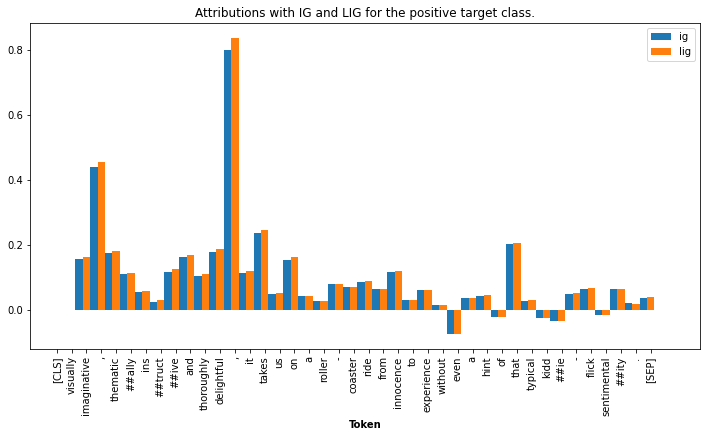

In [49]:
# Attributions for input_ids computed wit IG and LIG
# word_embeddings: index 0
ig_1 = attributions_1[0].squeeze().sum(1)
lig_1 = layer_attributions_1[0].squeeze().sum(1)

tokens = tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])

range_ig = [x + 0.5 for x in np.arange(len(ig_1))]
range_lig = [x + 0.5 for x in range_ig]
 
plt.rcParams["figure.figsize"] = [12, 6] 
plt.bar(range_ig, ig_1, width=0.5, label='ig')
plt.bar(range_lig, lig_1, width=0.5, label='lig')
plt.xlabel('Token', fontweight='bold')
plt.xticks(list(range(len(lig_1))), tokens, rotation='vertical')
plt.legend()
plt.title("Attributions with IG and LIG for the positive target class.")
plt.show()

**Plot for both target classes**

Attributions assigned to tokens may take opposite values when computed with regard to class 0 and class 1.


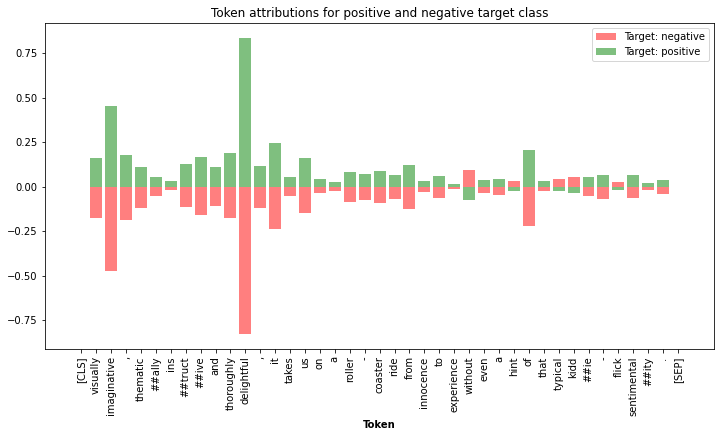

In [50]:
# Attributions for word_embeddings: index 0
lig_0 = layer_attributions_0[0].squeeze().sum(1)
lig_1 = layer_attributions_1[0].squeeze().sum(1)

tokens = tokenizer.convert_ids_to_tokens(tokenizer(text)["input_ids"])

plt.rcParams["figure.figsize"] = [12, 6]
plt.bar(list(range(len(lig_0))), lig_0, color='r', alpha=0.5)
plt.bar(list(range(len(lig_1))), lig_1, color='g', alpha=0.5)
plt.xticks(list(range(len(lig_0))), tokens, rotation='vertical')
plt.legend(labels=["Target: negative", "Target: positive"])
plt.xlabel('Token', fontweight='bold')
plt.title("Token attributions for positive and negative target class")
plt.show()

## Visualization

### Helper functions

In [51]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def compute_attributions_ig(ig, input_data_embed):
    # Create interpretable layer
    if not type(
        model.get_input_embeddings()).__name__ == "InterpretableEmbeddingBase":    
        interpretable_embedding1, interpretable_embedding2,\
        interpretable_embedding3 = configure_interpretable_embeddings()
    # Compute attributions for positive and nagative samples (class 1 and 0)
    attr_0, delta_0 = ig_attribute(ig, 0, input_data_embed)
    attr_1, delta_1 = ig_attribute(ig, 1, input_data_embed)
    # Remove interprateble layer used by ig attribution
    remove_interpretable_embeddings(interpretable_embedding1, 
                                    interpretable_embedding2, 
                                    interpretable_embedding3)
    # Return sum over all three layers
    attr_0 = torch.stack(attr_0, axis=0).sum(0)
    attr_1 = torch.stack(attr_1, axis=0).sum(0)    
    return (attr_0, delta_0), (attr_1, delta_1)    


def compute_attributions_lig(lig, input_data):  
    # Compute attributions for positive and nagative samples (class 1 and 0)
    return lig_attribute(lig, 0, input_data), lig_attribute(lig, 1, input_data)


def get_visualization_record(text, attributions, scores, true_label,
                             all_tokens, approximation_error):
    attributions_sum = summarize_attributions(attributions)
    return viz.VisualizationDataRecord(
        attributions_sum,
        torch.max(torch.softmax(scores[0], dim=0)),
        torch.argmax(scores),
        true_label,
        text,
        attributions_sum.sum(),
        all_tokens,
        approximation_error)
    

def visualize_attributions(text, true_label, ig_object, 
                           method, layer_name=None):
    # Prepare input
    input_data, input_data_embed = get_input_data(text)

    # Compute attributions
    attr_0, attr_1, delta_0, delta_1 = None, None, None, None
    if method == "ig":
        (attr_0, delta_0), (attr_1, delta_1) = \
        compute_attributions_ig(ig_object, input_data_embed)
    elif method == "lig":    
        (attr_0, delta_0), (attr_1, delta_1) = \
        compute_attributions_lig(ig_object, input_data)
    else:
        return "method: ig or lig"    
    # Run inference
    scores = predict_forward_func(*input_data[0:3], input_data[-1])
    # Prepare visualization 
    indices = input_data[0][0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    data_vis_0 = get_visualization_record(text, attr_0, scores, 
                                          true_label, all_tokens, delta_0)  
    data_vis_1 = get_visualization_record(text, attr_1, scores, 
                                          true_label, all_tokens, delta_1) 
    # Visualize
    print("\nAttribution method: {},".
          format(method), "class index: 0 (negative)")
    if not layer_name is None:
        print("Layer: {}".format(layer_name))
    viz.visualize_text([data_vis_0])
    print("Attribution method: {},".
          format(method), "Class index: 1 (positive)")
    if not layer_name is None:
        print("Layer: {}".format(layer_name))    
    viz.visualize_text([data_vis_1])
     
    return attr_0, attr_1    

### Examples

Captum visualization library shows in green tokens that push the prediction towards the target class. Those driving the score towards the reference value are marked in red. As a result, words perceived as positive will appear in green if attribution is performed against class 1 (positive) but will be highlighted in red with an attribution targeting class 0 (negative).

Because importance scores ar assigned to tokens, not words, some examples may show, that attribution is highly dependent on tokenization. Classification result may vary between runs.


Browse examples:

In [52]:
# Run predictions
eval_pred_result = trainer.predict(eval_dataset)
predictions = np.argmax(eval_pred_result.predictions, axis=1)

# Find misclassifed samples
eval_samples = [tokenizer.decode(x.input_ids, skip_special_tokens=True) \
                for x in eval_dataset]
eval_preds = list(zip(eval_pred_result.label_ids, predictions))
positive_pred_as_positive = [sample for sample, (real_label, pred_label) \
                             in zip(eval_samples, eval_preds) \
                             if real_label == pred_label and real_label == 1]  
negative_pred_as_negative = [sample for sample, (real_label, pred_label) \
                             in zip(eval_samples, eval_preds) \
                             if real_label == pred_label and real_label == 0]                               
negative_pred_as_positive = [sample for sample, (real_label, pred_label) \
                             in zip(eval_samples, eval_preds) \
                             if real_label != pred_label and real_label == 0]
positive_pred_as_negative = [sample for sample, (real_label, pred_label) \
                             in zip(eval_samples, eval_preds) \
                             if real_label != pred_label and real_label == 1]

# Browse
# print('\n'.join(positive_pred_as_positive))   
# print('\n'.join(negative_pred_as_negative))    
# print('\n'.join(negative_pred_as_positive))     
# print('\n'.join(positive_pred_as_negative))                                          

#### Positive

A correctly classified positive sample

Use our example or pick your own by setting `text_vis` and `true_label_vis` variables.

In [53]:
text_vis = text
true_label_vis = true_label

ig_0, ig_1 = visualize_attributions(text_vis, true_label_vis, ig, "ig")
lig_0, lig_1 = \
visualize_attributions(text_vis, true_label_vis, lig_we, "lig",
                       layer_name="electra.embeddings.word_embeddings")

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "



Attribution method: ig, class index: 0 (negative)


Attribution method: ig, Class index: 1 (positive)



Attribution method: lig, class index: 0 (negative)
Layer: electra.embeddings.word_embeddings


Attribution method: lig, Class index: 1 (positive)
Layer: electra.embeddings.word_embeddings


#### Negative

A correctly classified negative sample

Use our example or pick your own by setting `text_vis` and `true_label_vis` variables.

In [55]:
text_vis = 'the film makes a fatal mistake : it asks us to care about a young \
man whose only apparent virtue is that he is not quite as unpleasant as some \
of the people in his life.'
true_label_vis = 0

ig_0, ig_1 = visualize_attributions(text_vis, true_label_vis, ig, "ig")
lig_0, lig_1 = \
visualize_attributions(text_vis, true_label_vis, lig_we, "lig",
                       layer_name="electra.embeddings.word_embeddings")

/usr/local/lib/python3.6/dist-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "



Attribution method: ig, class index: 0 (negative)


Attribution method: ig, Class index: 1 (positive)



Attribution method: lig, class index: 0 (negative)
Layer: electra.embeddings.word_embeddings


Attribution method: lig, Class index: 1 (positive)
Layer: electra.embeddings.word_embeddings


#### Misclassified

Negative examples misclassified as positive

In [56]:
print('\n\n'.join(negative_pred_as_positive)) 

unflinchingly bleak and desperate

the script kicks in, and mr. hartley's distended pace and foot - dragging rhythms follow.

you won't like roger, but you will quickly recognize him.

this riveting world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms.

sam mendes has become valedictorian at the school for soft landings and easy ways out.

every nanosecond of the the new guy reminds you that you could be doing something else far more pleasurable.

it seems to me the film is about the art of ripping people off without ever letting them consciously know you have done so

pumpkin means to be an outrageous dark satire on fraternity life, but its ambitions far exceed the abilities of writer adam larson broder and his co - director, tony r. abrams, in their feature debut.

the best that can be said about the work here of scottish director ritchie... is that he obviously doesn't have his heart in it.

determined to b

Positive examples misclassified as negative

In [61]:
print('\n\n'.join(positive_pred_as_negative)) 

we root for ( clara and paul ), even like them, though perhaps it's an emotion closer to pity.

one of creepiest, scariest movies to come along in a long, long time, easily rivaling blair witch or the others.

though it's become almost redundant to say so, major kudos go to leigh for actually casting people who look working - class.

if steven soderbergh's ` solaris'is a failure it is a glorious failure.

a full world has been presented onscreen, not some series of carefully structured plot points building to a pat resolution.

a coda in every sense, the pinochet case splits time between a minute - by - minute account of the british court's extradition chess game and the regime's talking - head survivors.

as unseemly as its title suggests.

minority report is exactly what the title indicates, a report.

while there's something intrinsically funny about sir anthony hopkins saying ` get in the car, bitch,'this jerry bruckheimer production has little else to offer

you'll gasp appalled a

Pick an example

In [64]:
#text_vis = "<sample>"
#true_label_vis = 0

#ig_0, ig_1 = visualize_attributions(text_vis, true_label_vis, ig, "ig")
#lig_0, lig_1 = \
#visualize_attributions(text_vis, true_label_vis, lig_we, "lig",
#                       layer_name="electra.embeddings.word_embeddings")

# References

---

https://captum.ai/tutorials/Bert_SQUAD_Interpret

https://captum.ai/docs/algorithms

https://captum.ai/api/integrated_gradients.html

https://github.com/google-research/electra/

https://github.com/google-research/electra/blob/master/configure_finetuning.py

https://github.com/huggingface/nlp/blob/master/notebooks/Overview.ipynb

https://huggingface.co/transformers/main_classes/trainer.html